In [2]:
from huggingface_hub import hf_hub_download
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pickle 
import os
import sys

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from hyperopt import hp, tpe, fmin, Trials, rand
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

from preprocessing.utils import *
import warnings
warnings.filterwarnings("ignore")

!set HF_HUB_DISABLE_SYMLINKS_WARNING=true
REPO_ID = "inria-soda/tabular-benchmark"
reg_num = ['Brazilian_houses.csv']


def sample_hpt_from_space(space, n_samples=100):
    return [sample(space) for _ in range(n_samples)]
def print_info(iter_number, total_iterations, dct=None):
    arrow_length = 30
    progress = int((iter_number / total_iterations) * arrow_length)
    progress_bar = "=" * progress + ">"
    info_string = "\rIteration: [{:<30}] {}/{}".format(progress_bar, iter_number, total_iterations)
    if dct is not None:
        info_string += ", {}".format(dct)
    sys.stdout.write(info_string.ljust(100))  # Adjust the total length as needed
    sys.stdout.flush()

def preprocess_data(X, y, isCategorical):
    # Handle missing values
    X = X.dropna(axis=1, how='any')
    y = y.dropna(axis=0, how='any')
    X = X.dropna(axis=0, how='any')
    
    # Handle categorical data
    if isCategorical:
        for col in X.select_dtypes(include=['object']).columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
    return X, y

def split_data(X, y, isCategorical):
    if isCategorical:
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    else:
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

def evaluate_model(model, X_train, y_train, X_test, y_test, X_val, y_val):
    model.fit(X_train, y_train)
    val_predict = model.predict(X_val)
    test_predict = model.predict(X_test)
    train_predict = model.predict(X_train)
    val_score = r2_score(y_val, val_predict)
    test_score = r2_score(y_test, test_predict)
    train_score = r2_score(y_train, train_predict)
    hyperparameters = model.get_params()
    return {'val_r2_score': val_score, 
            'test_r2_score': test_score, 
            'train_r2_score': train_score, 
            'hyperparameters': hyperparameters}

if not os.path.exists('gradient-boosting-results'):
    os.makedirs('gradient-boosting-results')


if not os.path.exists('random-forest-results'):
    os.makedirs('random-forest-results')
    
if not os.path.exists('xgboost-results'):
    os.makedirs('xgboost-results')

np.random.seed(42)
n_iterations = 30
n_shuffles = 5
random_shuffle_indices = np.array([np.random.permutation(n_iterations) for _ in range(n_shuffles)])

reg_num_random_forest_scores = np.zeros((n_shuffles, n_iterations))
reg_num_gradient_boosting_scores = np.zeros((n_shuffles, n_iterations))
reg_num_xgboost_scores = np.zeros((n_shuffles, n_iterations))

random_forest_hyperparameter_space = {
    'criterion': hp.choice('criterion', ['squared_error', 'friedman_mse','absolute_error']),
    'n_estimators': scope.int(hp.loguniform('n_estimators', np.log(9.5), np.log(3000.5))),
    'max_depth': hp.choice('max_depth', [None, 2, 3, 4]),
    'min_samples_split': hp.pchoice('min_samples_split', [(0.95, 2), (0.05, 3)]),
    'min_samples_leaf': scope.int(hp.loguniform('min_samples_leaf', np.log(1.5), np.log(50.5))),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_features': hp.choice('max_features', ['sqrt', 'sqrt', 'log2', None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    'min_impurity_decrease': hp.pchoice('min_impurity_decrease', [
        (0.85, 0.0), 
        (0.05, 0.01), 
        (0.05, 0.02), 
        (0.05, 0.05)
    ])       
}
random_forest_hpt_samples = sample_hpt_from_space(random_forest_hyperparameter_space, n_samples=n_iterations)

gradient_boosting_hyperparameter_space = {
    'loss': hp.choice('loss', ['squared_error', 'huber', 'quantile']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(10)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'n_estimators': scope.int(hp.qloguniform('n_estimators', np.log(10.5), np.log(1000.5), 1)),
    'criterion': hp.choice('criterion', ['friedman_mse', 'squared_error']),
    'max_depth': hp.pchoice('max_depth', [(0.1, None), (0.1, 2), (0.1, 3), (0.6, 4), (0.1, 5)]),
    'min_samples_split': hp.pchoice('min_samples_split', [(0.95, 2), (0.05, 3)]),
    'min_samples_leaf': scope.int(hp.qloguniform('min_samples_leaf', np.log(1.5), np.log(50.5), 1)),
    'min_impurity_decrease': hp.pchoice('min_impurity_decrease', [(0.85, 0.0), (0.05, 0.01), (0.05, 0.02), (0.05, 0.05)]),
    'max_leaf_nodes': hp.pchoice('max_leaf_nodes', [(0.85, None), (0.05, 5), (0.05, 10), (0.05, 15)])
}
gradient_boosting_hpt_samples = sample_hpt_from_space(gradient_boosting_hyperparameter_space, n_samples=n_iterations)

xgboost_hyperparameter_space = {
    'max_depth': hp.uniformint('max_depth', 1, 11),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 6000, 200)),
    'min_child_weight': hp.qloguniform('min_child_weight', np.log(1), np.log(1e2), 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(0.7)),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(7)),
    'lambda': hp.loguniform('lambda', np.log(1), np.log(4)),
    'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1e2))
}
xgboost_hpt_samples = sample_hpt_from_space(xgboost_hyperparameter_space, n_samples=n_iterations)

for dataset_idx, dataset in enumerate(reg_num):
    print(f'Evaluating {dataset}...')

    df = pd.read_csv(
        hf_hub_download(repo_id=REPO_ID, filename=f'reg_num/{dataset}', repo_type="dataset")
    )
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    X, y = preprocess_data(X, y, isCategorical=False)
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y, isCategorical=False)
    print(f'Training data: {len(X_train)}\nValidation data: {len(X_val)}\nTesting data: {len(X_test)}')
    
    for random_shuffle_idx in range(n_shuffles):

        # Random Forest
        print('\nRunning Random Forest...')
        
        trials = []
        scores = []
        for hpt_idx, i in enumerate(random_shuffle_indices[random_shuffle_idx]):
            print_info(hpt_idx + 1, n_iterations)
            hyperparameters = random_forest_hpt_samples[i]
            if hpt_idx == 0:
                model = RandomForestRegressor()
            else:
                model = RandomForestRegressor(**hyperparameters)
            trial_result = evaluate_model(model, X_train, y_train, X_test, y_test, X_val, y_val)
            trials.append(trial_result)
            scores.append(trial_result['val_r2_score'])
       
        with open(os.path.join('random-forest-results', f'{dataset}_shuffle_{random_shuffle_idx}.pkl'), 'wb') as f:
            pickle.dump(trials, f)
                  
        reg_num_random_forest_scores[random_shuffle_idx, :] = scores

        # Gradient Boosting
        print('\nRunning Gradient Boosting')

        trials = []
        scores = []
        for hpt_idx, i in enumerate(random_shuffle_indices[random_shuffle_idx]):
            print_info(hpt_idx + 1, n_iterations)
            hyperparameters = gradient_boosting_hpt_samples[i]
            if hpt_idx == 0:
                model = GradientBoostingRegressor()
            else:
                model = GradientBoostingRegressor(**hyperparameters)
            trial_result = evaluate_model(model, X_train, y_train, X_test, y_test, X_val, y_val)
            trials.append(trial_result)
            scores.append(trial_result['val_r2_score'])
        
        with open(os.path.join('gradient-boosting-results', f'{dataset}_shuffle_{random_shuffle_idx}.pkl'), 'wb') as f:
            pickle.dump(trials, f)
                  
        reg_num_gradient_boosting_scores[random_shuffle_idx, :] = scores
        
        # XGBoost
        print('\nRunning XGBoost')
        
        trials = []
        scores = []
        for hpt_idx, i in enumerate(random_shuffle_indices[random_shuffle_idx]):
            print_info(hpt_idx + 1, n_iterations)
            hyperparameters = xgboost_hpt_samples[i]
            if hpt_idx == 0:
                model = XGBRegressor(n_jobs=16)
            else:
                model = XGBRegressor(**hyperparameters, n_jobs=16)
            trial_result = evaluate_model(model, X_train, y_train, X_test, y_test, X_val, y_val)
            trials.append(trial_result)
            scores.append(trial_result['val_r2_score'])
        
        with open(os.path.join('xgboost-results', f'{dataset}_shuffle_{random_shuffle_idx}.pkl'), 'wb') as f:
            pickle.dump(trials, f)
                  
        reg_num_xgboost_scores[random_shuffle_idx, :] = scores

Evaluating Brazilian_houses.csv...
Training data: 7484
Validation data: 1604
Testing data: 1604

Running Random Forest...
Iteration: [==============================>] 30/30                                                 
Running Gradient Boosting
Iteration: [==============================>] 30/30                                                 
Running XGBoost
Iteration: [==============================>] 30/30                                                 
Running Random Forest...
Iteration: [==============================>] 30/30                                                 
Running Gradient Boosting
Iteration: [==============================>] 30/30                                                 
Running XGBoost
Iteration: [==============================>] 30/30                                                 
Running Random Forest...
Iteration: [==============================>] 30/30                                                 
Running Gradient Boosting
Iteration: [======

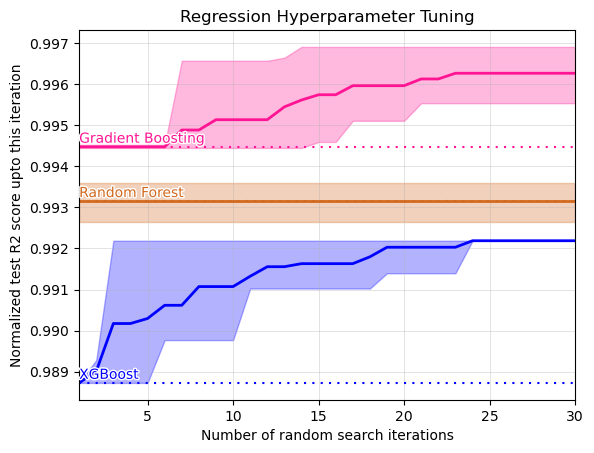

In [3]:
x = range(1, n_iterations + 1)

xgboost_best_values = np.maximum.accumulate(reg_num_xgboost_scores, axis=1)
random_forest_best_values = np.maximum.accumulate(reg_num_random_forest_scores, axis=1)
gradient_boost_best_values = np.maximum.accumulate(reg_num_gradient_boosting_scores, axis=1)

plt.axhline(y=reg_num_xgboost_scores[:, 0].mean(), color='blue', linestyle=(0, (1, 3)))
plt.axhline(y=reg_num_random_forest_scores[:, 0].mean(), color='chocolate', linestyle=(0, (1, 3)))
plt.axhline(y=reg_num_gradient_boosting_scores[:, 0].mean(), color='deeppink', linestyle=(0, (1, 3)))

text = plt.text(1, reg_num_xgboost_scores[:, 0].mean() + 0.0001, f'XGBoost', color='blue')
text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='white')])
text = plt.text(1, reg_num_random_forest_scores[:, 0].mean() + 0.0001, f'Random Forest', color='chocolate')
text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='white')])
text = plt.text(1, reg_num_gradient_boosting_scores[:, 0].mean() + 0.0001, f'Gradient Boosting', color='deeppink')
text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='white')])

plt.plot(x, xgboost_best_values.mean(axis=0), label='XGBoost', color='blue', linewidth=2)
plt.plot(x, random_forest_best_values.mean(axis=0), label='Random Forest', color='chocolate', linewidth=2)
plt.plot(x, gradient_boost_best_values.mean(axis=0), label='Gradient Boosting', color='deeppink', linewidth=2)

plt.fill_between(x, xgboost_best_values.min(axis=0), xgboost_best_values.max(axis=0), color='blue', alpha=0.3)
plt.fill_between(x, random_forest_best_values.min(axis=0), random_forest_best_values.max(axis=0), color='chocolate', alpha=0.3)
plt.fill_between(x, gradient_boost_best_values.min(axis=0), gradient_boost_best_values.max(axis=0), color='deeppink', alpha=0.3)

plt.xticks(range(0, n_iterations+1, 5))
plt.xlim(1, n_iterations)

plt.ylabel('Normalized test R2 score upto this iteration')
plt.xlabel('Number of random search iterations')
plt.title('Regression Hyperparameter Tuning')
plt.grid(True, which='both', linewidth=0.5, alpha=0.5)

plt.show()